In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Classification with sklearn and tf

In this notebook, we content ourselves with trying to classify colourmaps as 'rainbow' or not. 

In [2]:
CMAPS = {'Perceptual':
                            ['viridis', 'inferno', 'plasma', 'magma'],
         'Diverging':      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic'],
         'Qualitative':    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3'],
         'Other':  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 
                             'gnuplot', 'gnuplot2',],
         'Rainbow':  ['gist_ncar', 'nipy_spectral', 'jet',
                             'gist_rainbow', 'hsv'],
        }

In [5]:
def kernel(sizex, sizey):
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
    return g / g.sum()

In [6]:
import scipy.signal

def make_map(n, nx=100, ny=100, kernel_size=None, seed=None):

    imgs = []
    for i in range(n):
        rng = np.random.RandomState(seed=seed)
        z = rng.rand(nx, ny)
        kernel_size = kernel_size or (30, 30)
        f = kernel(*kernel_size)

        z = scipy.signal.convolve(z, f, mode='valid')
        z = (z - z.min())/(z.max() - z.min())
        imgs.append(z)
    
    return np.stack(imgs)

In [25]:
n = 1000
map_data = make_map(n, kernel_size=(29,29))

nv = 250
map_data_val = make_map(nv, kernel_size=(29,29))

In [26]:
map_data.shape

(1000, 42, 42)

## Make seismic data

In [9]:
raw = np.load("/home/matt/Dropbox/dev/geocomp-19/data/F3_volume_3x3_16bit.npy")

In [10]:
def rms(arr):
    epsilon=1e-6
    return np.sqrt(epsilon + np.sum(arr**2)/arr.size)

In [11]:
def make_seismic(raw, n=1600, s=32):
    slices = []
    while len(slices) < n:
        x, y, z = [np.random.randint(0, h) for h in np.array(raw.shape)-np.array([s, 0, s])]
        this = raw[x:x+s, y, z:z+s]
        if rms(this) < 1:
            # Make sure it's not blank
            continue
        slices.append(this.T)
    data = np.array(slices, dtype=np.int64)

    mi, ma = np.percentile(data, (0.5, 99.5))
    data[data < mi] = mi
    data[data > ma] = ma

    data[np.isnan(data)] = 0
    mi, ma = np.min(data), np.max(data)
    data = (data - mi) / (ma - mi)

    data = data.astype(np.float32)
    return data

In [12]:
n = 1000
seis_data = make_seismic(raw, n=n, s=42)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
np.min(seis_data), np.max(seis_data)

(0.0, 1.0)

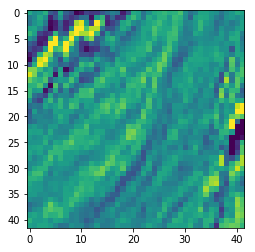

In [14]:
plt.imshow(seis_data[313])

In [27]:
nv = 250
seis_data_val = make_seismic(raw, n=nv, s=42)

/home/matt/anaconda3/envs/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


## Concatenate

In [28]:
data = np.vstack([map_data, seis_data])
data_val = np.vstack([map_data_val, seis_data_val])
data.shape, data_val.shape

((2000, 42, 42), (500, 42, 42))

## Make `X` and `y`

In [17]:
CLASSES = {}
for k, v in CMAPS.items():
    for cmap in v:
        CLASSES[cmap] = k
CLASSES

{'viridis': 'Perceptual',
 'inferno': 'Perceptual',
 'plasma': 'Perceptual',
 'magma': 'Perceptual',
 'BrBG': 'Diverging',
 'bwr': 'Diverging',
 'coolwarm': 'Diverging',
 'PiYG': 'Diverging',
 'PRGn': 'Diverging',
 'PuOr': 'Diverging',
 'RdBu': 'Diverging',
 'RdGy': 'Diverging',
 'RdYlBu': 'Diverging',
 'RdYlGn': 'Diverging',
 'Spectral': 'Diverging',
 'seismic': 'Diverging',
 'Accent': 'Qualitative',
 'Dark2': 'Qualitative',
 'Paired': 'Qualitative',
 'Pastel1': 'Qualitative',
 'Pastel2': 'Qualitative',
 'Set1': 'Qualitative',
 'Set2': 'Qualitative',
 'Set3': 'Qualitative',
 'gist_earth': 'Other',
 'terrain': 'Other',
 'ocean': 'Other',
 'gist_stern': 'Other',
 'brg': 'Other',
 'CMRmap': 'Other',
 'gnuplot': 'Other',
 'gnuplot2': 'Other',
 'gist_ncar': 'Rainbow',
 'nipy_spectral': 'Rainbow',
 'jet': 'Rainbow',
 'gist_rainbow': 'Rainbow',
 'hsv': 'Rainbow'}

In [18]:
import os
import random

from matplotlib import cm
from functools import reduce

def make_X_and_y(data):
    
    pseudos, classes = [], []

    for d in data:
        cmap_, class_ = random.choice(list(CLASSES.items()))
        cmap = cm.get_cmap(cmap_)
    
        pseudo = cmap(d)[..., :3]
        
        pseudos.append(pseudo)
        classes.append(class_)
        
    return np.stack(pseudos), np.stack(classes)

In [ ]:
np.random.shuffle()

In [19]:
def display_slices(data, labels, preds=None, probs=None):
    fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(12,5))
    if preds is None:
        preds = [None for _ in labels]
    if probs is None:
        probs = [None for _ in labels]
    for ax, d, label, pred, prob in zip(axs.flatten(), data, labels, preds, probs):
        ax.imshow(d, aspect='1')
        ax.axis('off')
        if pred is None:
            ax.set_title(label)
        else:
            ax.set_title(f"{pred} {prob:0.3f}\n{label}")
    plt.show()

### Training set

In [20]:
X, y = make_X_and_y(data)

In [21]:
X.shape, y.shape

((2000, 42, 42, 3), (2000,))

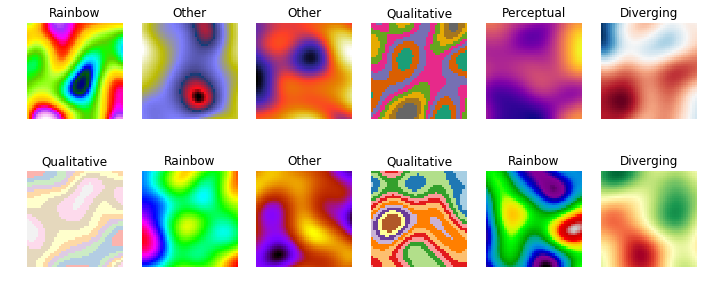

In [22]:
display_slices(X, y)

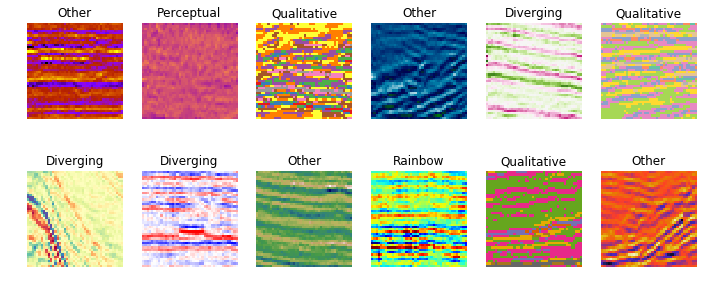

In [52]:
display_slices(X[::-1], y[::-1])

In [23]:
n = X.shape[0]

X_train, y_train = X.reshape((n, -1)), y

In [24]:
X_train.shape

(2000, 5292)

### Validation set

In [29]:
X_val, y_val = make_X_and_y(data_val)

In [30]:
X_val.shape, y_val.shape

((500, 42, 42, 3), (500,))

In [31]:
nv = X_val.shape[0]

X_val, y_val = X_val.reshape((nv, -1)), y_val

----

## Training

### Random forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=12,
                            min_samples_leaf=2,
                            n_jobs=6,
                            n_estimators=200,
                            random_state=42,
                           )

In [83]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=6,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [84]:
rf.classes_

array(['Diverging', 'Other', 'Perceptual', 'Qualitative', 'Rainbow'],
      dtype='<U11')

In [85]:
y_prob = rf.predict_proba(X_val)

y_pred = rf.classes_[np.argmax(y_prob, axis=-1)]

In [86]:
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='weighted')

0.9420862856542237

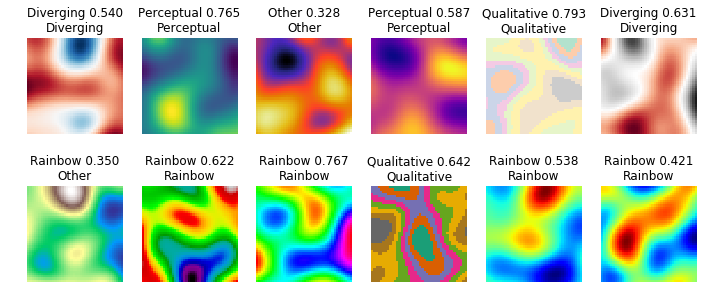

In [87]:
display_slices(X_val.reshape(nv, 42, 42, 3), y_val, y_pred, np.max(y_prob, axis=-1))

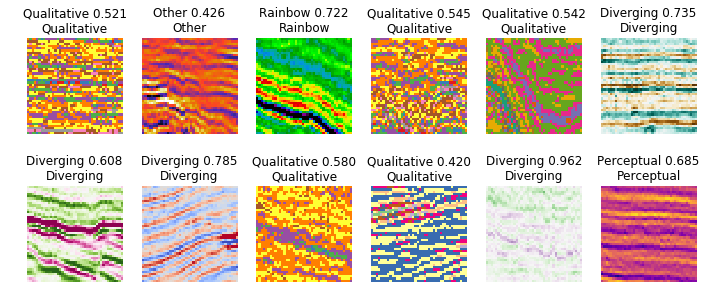

In [88]:
display_slices(X_val.reshape(nv, 42, 42, 3)[::-1], y_val[::-1], y_pred[::-1], np.max(y_prob, axis=-1)[::-1])

In [89]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

  Diverging       0.96      0.94      0.95       161
      Other       0.95      0.88      0.92        95
 Perceptual       0.96      0.98      0.97        52
Qualitative       0.88      0.97      0.92       118
    Rainbow       0.99      0.96      0.97        74

avg / total       0.94      0.94      0.94       500



In [90]:
for i, class_ in enumerate(nn.classes_):
    confmat = confusion_matrix(y_val, y_pred)
    s = f"{class_:<12s} {{:4d}} {{:4d}} {{:4d}} {{:4d}} {{:4d}}"
    print(s.format(*confmat[i]))

Diverging     151    2    0    8    0
Other           3   84    2    5    1
Perceptual      0    1   51    0    0
Qualitative     3    1    0  114    0
Rainbow         1    0    0    2   71


### Neural net

In [32]:
from sklearn.neural_network import MLPClassifier

hidden = [ 32, 64, 16 ]

nn = MLPClassifier(hidden_layer_sizes=hidden,
                  max_iter=10*n,
                  random_state=42,
                 )

In [33]:
nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[32, 64, 16], learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [34]:
nn.classes_

array(['Diverging', 'Other', 'Perceptual', 'Qualitative', 'Rainbow'],
      dtype='<U11')

In [35]:
y_prob = nn.predict_proba(X_val)

y_pred = nn.classes_[np.argmax(y_prob, axis=-1)]

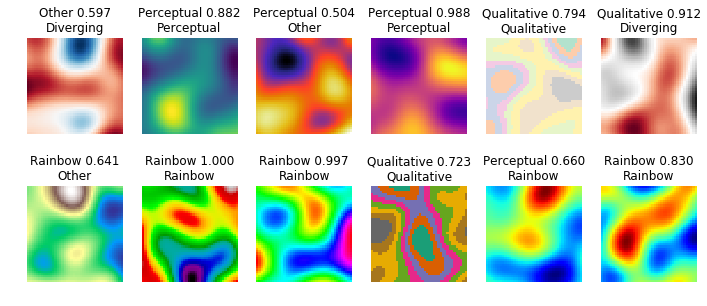

In [36]:
display_slices(X_val.reshape(nv, 42, 42, 3), y_val, y_pred, np.max(y_prob, axis=-1))

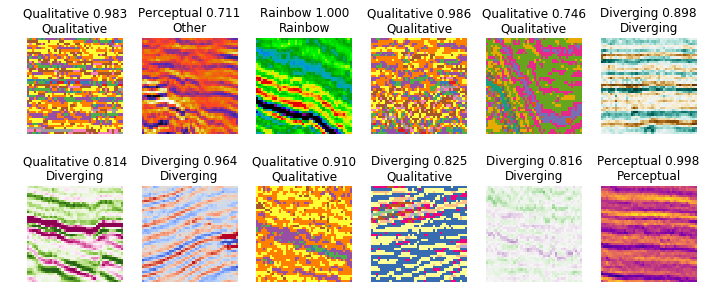

In [53]:
display_slices(X_val.reshape(nv, 42, 42, 3)[::-1], y_val[::-1], y_pred[::-1], np.max(y_prob, axis=-1)[::-1])

In [54]:
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='weighted')

0.7443765226674177

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

  Diverging       0.74      0.76      0.75       161
      Other       0.81      0.58      0.67        95
 Perceptual       0.68      0.94      0.79        52
Qualitative       0.68      0.81      0.74       118
    Rainbow       0.94      0.69      0.80        74

avg / total       0.76      0.75      0.74       500



## Test on unseen colourmap

#### SEISMIC

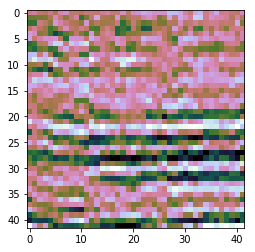

In [136]:
d = make_seismic(raw, n=1, s=42)

cmap = cm.get_cmap('cubehelix')
im = cmap(d[0])[..., :3]

plt.imshow(im)

In [139]:
Xs = im.reshape(1, -1)

p = rf.predict_proba(Xs)
rf.classes_[np.argmax(p)]

'Other'

In [140]:
p = nn.predict_proba(Xs)
nn.classes_[np.argmax(p)]

'Diverging'

#### MAP

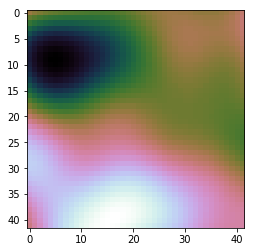

In [144]:
d = make_map(n=1, kernel_size=(29,29))

cmap = cm.get_cmap('cubehelix')
im = cmap(d[0])[..., :3]

plt.imshow(im)

In [147]:
Xm = im.reshape(1, -1)

p = rf.predict_proba(Xm)
rf.classes_[np.argmax(p)]

'Other'

In [152]:
p = nn.predict_proba(Xm)
nn.classes_[np.argmax(p)]

'Diverging'